# CS188 Project 2 - Binary Classification Comparative Methods

For this project we're going to attempt a binary classification of a dataset using multiple methods and compare results. 

Our goals for this project will be to introduce you to several of the most common classification techniques, how to perform them and tweek parameters to optimize outcomes, how to produce and interpret results, and compare performance. You will be asked to analyze your findings and provide explanations for observed performance. 

Specifically you will be asked to classify whether a <b>patient is suffering from heart disease</b> based on a host of potential medical factors.

<b><u>DEFINITIONS</b></u>


<b> Binary Classification:</b>
In this case a complex dataset has an added 'target' label with one of two options. Your learning algorithm will try to assign one of these labels to the data.

<b> Supervised Learning:</b>
This data is fully supervised, which means it's been fully labeled and we can trust the veracity of the labeling.

## Background: The Dataset 

For this exercise we will be using a subset of the UCI Heart Disease dataset, leveraging the fourteen most commonly used attributes. All identifying information about the patient has been scrubbed. 

The dataset includes 14 columns. The information provided by each column is as follows:
<ul>
    <li><b>age:</b> Age in years</li>
    <li><b>sex:</b> (1 = male; 0 = female)</li>
    <li><b>cp:</b> Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)</li>
    <li><b>trestbps:</b> Resting blood pressure (in mm Hg on admission to the hospital)</li>
    <li><b>cholserum:</b> Cholestoral in mg/dl</li>
    <li><b>fbs</b> Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)</li>
    <li><b>restecg:</b> Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))</li>
    <li><b>thalach:</b> Maximum heart rate achieved</li>
    <li><b>exang:</b> Exercise induced angina (1 = yes; 0 = no)</li>
    <li><b>oldpeakST:</b> Depression induced by exercise relative to rest</li>
    <li><b>slope:</b> The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)</li>
    <li><b>ca:</b> Number of major vessels (0-3) colored by flourosopy</li>
    <li><b>thal:</b> 1 = normal; 2 = fixed defect; 7 = reversable defect</li>
    <li><b><u>Sick:</u></b> Indicates the presence of Heart disease (True = Disease; False = No disease)</li>
</ul>
    


## Loading Essentials and Helper Functions 

In [2]:
#Here are a set of libraries we imported to complete this assignment. 
#Feel free to use these or equivalent libraries for your implementation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import os
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold


from matplotlib import pyplot
import itertools

%matplotlib inline

import random 
  
random.seed(42) 

In [3]:
# Helper function allowing you to export a graph
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:


# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## Part 1. Load the Data and Analyze

Let's first load our dataset so we'll be able to work with it. (correct the relative path if your notebook is in a different directory than the csv file.)

In [8]:
hddata = pd.read_csv("heartdisease.csv")

### Now that our data is loaded, let's take a closer look at the dataset we're working with. Use the head method,  the describe method, and the info method to display some of the rows so we can visualize the types of data fields we'll be working with.

### Sometimes data will be stored in different formats (e.g., string, date, boolean), but many learning methods work strictly on numeric inputs. Call the info method to determine the datafield type for each column. Are there any that are problemmatic and why?

In [9]:
hddata.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sick
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,False
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,False
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,False
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,False
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,False


In [11]:
hddata.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000


In [12]:
hddata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  sick      303 non-null    bool   
dtypes: bool(1), float64(1), int64(12)
memory usage: 31.2 KB


[Use this area to describe any fields you believe will be problemmatic and why] 

All the columns in our dataframe are numeric (either int or float), however our target variable 'sick' is a boolean and may need to be modified.

cp, fbs, restecg, exang, slope, ca, and thal are numeria, but they are categorical variables and the numeric value might be problematic when doing analysis such as linear regression because they don't represent arthematic operations.

### Determine if we're dealing with any null values. If so, report on which columns? 

In [14]:
incomplete_rows = hddata[hddata.isnull().any(axis=1)].head()
incomplete_rows

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sick


There are no null values.

### Before we begin our analysis we need to fix the field(s) that will be problematic. Specifically convert our boolean sick variable into a binary numeric target variable (values of either '0' or '1'), and then drop the original sick datafield from the dataframe. (hint: try label encoder or .astype()

In [19]:
hddata['sick'] = hddata['sick'].astype(int) #num.astype.(type) change value type


### Now that we have a feel for the data-types for each of the variables, plot histograms of each field and attempt to ascertain how each variable performs (is it a binary, or limited selection, or does it follow a gradient? 

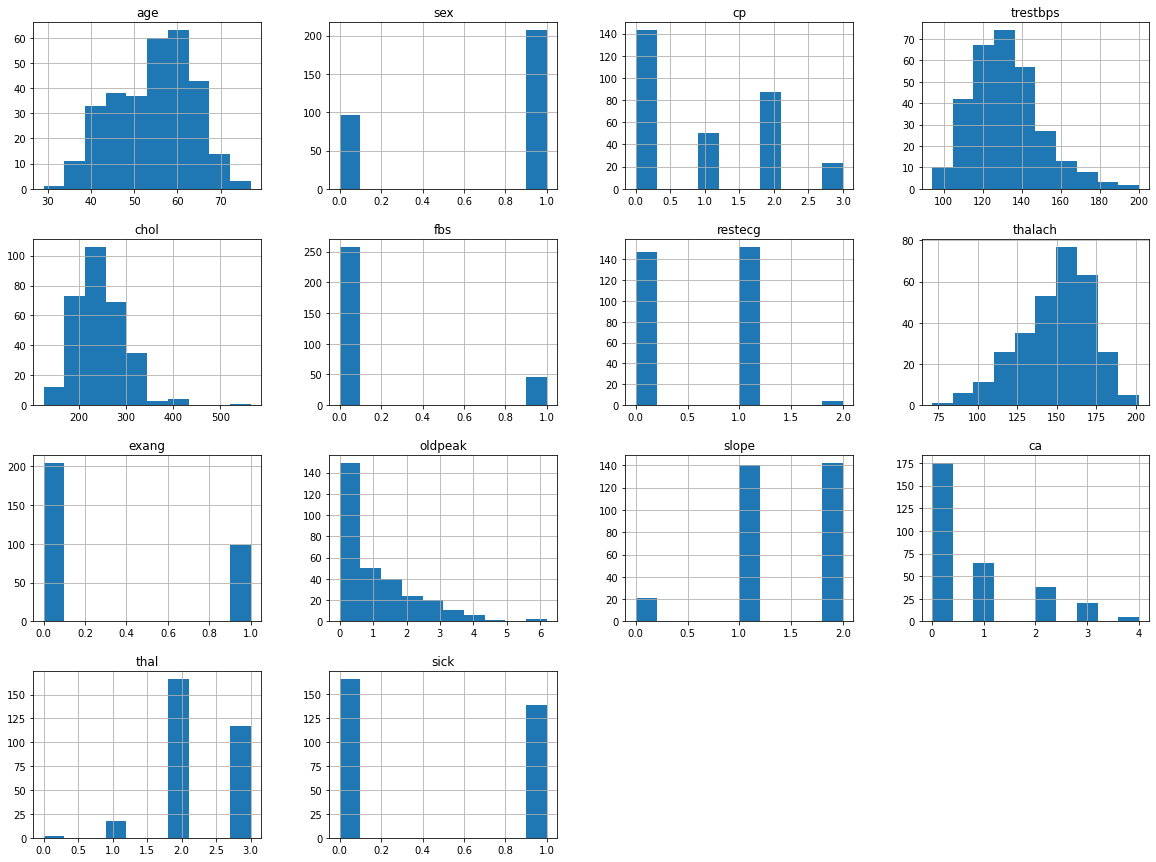

In [21]:
hddata.hist(figsize=(20,15))
plt.show()

Binary: sex, fbs, exang, sick(response variable)

Limited selection: cp, restecg, slope, ca, thal

gradient: age, trestbps, chol, thalach, oldpeak

### We also want to make sure we are dealing with a balanced dataset. In this case, we want to confirm whether or not we have an equitable number of  sick and healthy individuals to ensure that our classifier will have a sufficiently balanced dataset to adequately classify the two. Plot a histogram specifically of the sick target, and conduct a count of the number of sick and healthy individuals and report on the results: 

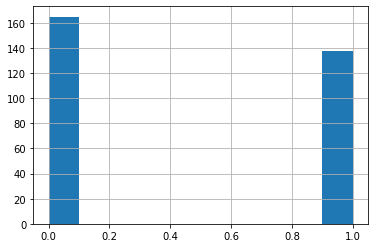

There are 138 sick individuals and 165 healthy individuals


In [39]:
hddata["sick"].hist()
plt.show()
sick = hddata.loc[(hddata['sick'] == 1)]
healthy = hddata.loc[(hddata['sick'] == 0)]
print("There are", sick.iloc[:,0].size, "sick individuals and", healthy.iloc[:,0].size,"healthy individuals")

The dataset is balanced because the number of sick and healthy people are within 4:1 or 1:4 ratio.

### Balanced datasets are important to ensure that classifiers train adequately and don't overfit, however arbitrary balancing of a dataset might introduce its own issues. Discuss some of the problems that might arise by artificially balancing a dataset.

There are many ways to deal with unbalanced data sets. For one, we can downsample the data sets and select a more balanced data set. For another, we can augment the dataset with synthetic data samples of minority class. Also, we can balance the weight of loss function to prioritize certain errors. However, after artificially balancing a dataset, there might be problems. For one, downsampling or augmenting the data sets might make the data sets less representative of the population(not accurate) because it might change the coorelation.  

### Now that we have our dataframe prepared let's start analyzing our data. For this next question let's look at the correlations of our variables to our target value. First, map out the correlations between the values, and then discuss the relationships you observe. Do some research on the variables to understand why they may relate to the observed corellations. Intuitively, why do you think some variables correlate more highly than others (hint: one possible approach you can use the sns heatmap function to map the corr() method)?

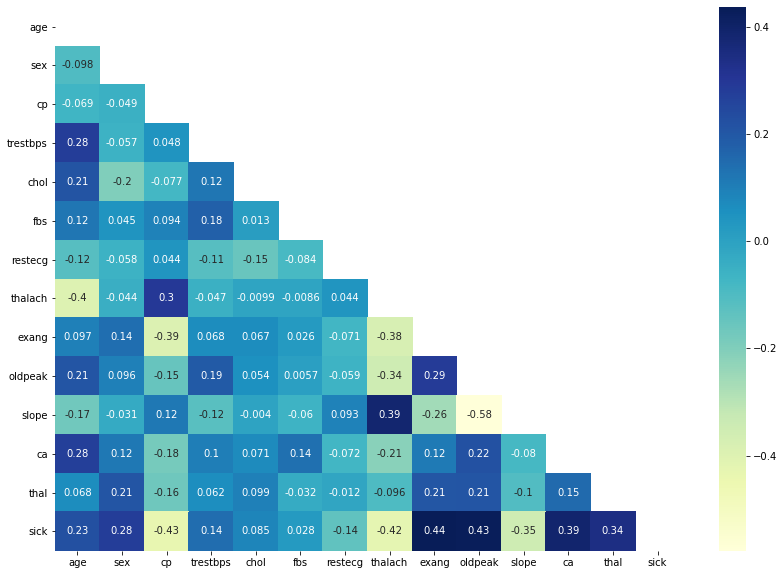

In [48]:
#the correlation of varables
corr = hddata.corr()

#mask only maintains low tri of map
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

#size of map
f, ax = plt.subplots(figsize=(14,10))

ax = sns.heatmap(corr, mask = mask, annot=True, cmap = 'YlGnBu') #annotation puts number on map, cmap is the color of map

For strong positive correlation, exang and sick(0.44), oldpeak and sick(0.43), slope and thalach (0.39), ca and sick(0.39), and thal and sick(0.34). I think exang and oldpeak have a strong relation to sick because both of them are exercise related sickness. Slope and thalach are related because exercise is related to max heart rate. ca and thal are both related to sick because vessesls and max heart rate are a significant sign of sickness. For strong negative correlation, slope and oldpeak(-0.58), age and thalach(0.4). I think slope and oldpeak and related because they are both related to exercise, and age and thalach are related because it's commonly known that people's heart rate goes down as age does up. 

## Part 2. Prepare the Data and run a KNN Model

Before running our various learning methods, we need to do some additional prep to finalize our data. Specifically you'll have to cut the classification target from the data that will be used to classify, and then you'll have to divide the dataset into training and testing cohorts.

Specifically, we're going to ask you to prepare 2 batches of data: 1. Will simply be the raw numeric data that hasn't gone through any additional pre-processing. The other, will be data that you pipeline using your own selected methods. We will then feed both of these datasets into a classifier to showcase just how important this step can be!

### Save the label column as a separate array and then drop it from the dataframe. 

In [111]:
hd_y = hddata['sick'].copy()
hd_X = hddata.drop('sick', axis = 1)

### First Create your 'Raw' unprocessed training data by dividing your dataframe into training and testing cohorts, with your training cohort consisting of 80% of your total dataframe (hint: use the train_test_split method) Output the resulting shapes of your training and testing samples to confirm that your split was successful.

In [112]:
from sklearn.model_selection import train_test_split
train, test, target, target_test = train_test_split(hd_X, hd_y, test_size=0.2, random_state=0)

print("training data x shape:", train.shape)
print("training data y shape:", target.shape)
print("test data x shape:", test.shape)
print("test data y shape:", target_test.shape)

training data x shape: (242, 13)
training data y shape: (242,)
test data x shape: (61, 13)
test data y shape: (61,)


### In lecture we learned about K-Nearest Neighbor. One thing we noted was because KNN's rely on Euclidean distance, they are highly sensitive to the relative magnitude of different features. Let's see that in action! Implement a K-Nearest Neighbor algorithm on our data and report the results. For this initial implementation simply use the default settings. Refer to the [KNN Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) for details on implementation. Report on the accuracy of the resulting model.

In [115]:
from sklearn.neighbors import KNeighborsClassifier
import sklearn as sk
from sklearn.linear_model import LogisticRegression

# k-NN for k=5
knn5 = KNeighborsClassifier(5)
knn5.fit(train,target)


KNeighborsClassifier(n_neighbors=25)

In [135]:
######
# 4. Report classification accuracy on both train and test set for all models.
######
print("Classification accuracy for knn5 were: \n Train =",
    knn5.score(train, target),", Test =", knn5.score(test, target_test))


Classification accuracy for knn5 were: 
 Train = 0.78099173553719 , Test = 0.639344262295082


### Now implement a pipeline of your choice. You can opt to handle categoricals however you wish, however please scale your numeric features using standard scaler

### Pipeline:

In [118]:
hd_unlabeled = hddata[["age", "oldpeak", "chol", "trestbps", "thalach"]].copy()# drop labels for training set features
                                                       # the input to the model should not contain the true label
hd_labeled = hddata.drop(["age", "oldpeak", "chol", "trestbps", "thalach", 'sick'], axis = 1)

In [119]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin

numerical_features = list(hd_unlabeled)
categorical_features = list(hd_labeled)

In [120]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(), categorical_features),
    ])

In [121]:
aX = hddata.drop('sick', axis = 1)

In [122]:
hddata_prepared = full_pipeline.fit_transform(aX)

### Now split your pipelined data into an 80/20 split and again run the same KNN, and report out on it's accuracy. Discuss the implications of the different results you are obtaining.

In [123]:
hd_y_pipe = hddata['sick'].copy()
hd_X_pipe = hddata_prepared

In [124]:
from sklearn.model_selection import train_test_split
train_pipe, test_pipe, target_pipe, target_test_pipe = train_test_split(hd_X_pipe, hd_y_pipe, test_size=0.2, random_state=0)

In [126]:
from sklearn.neighbors import KNeighborsClassifier
import sklearn as sk
from sklearn.linear_model import LogisticRegression

# k-NN for k=1, 15, and 25
knn5_pipe = KNeighborsClassifier(1)
knn5_pipe.fit(train_pipe,target_pipe)

KNeighborsClassifier(n_neighbors=1)

In [136]:
print("Classification accuracy for knn5 were: \n Train =",
    knn5_pipe.score(train_pipe,target_pipe),", Test =", knn5_pipe.score(test_pipe,target_test_pipe))

Classification accuracy for knn5 were: 
 Train = 1.0 , Test = 0.7704918032786885


I applied one-hot encoding in the pipeline. 

### Parameter Optimization.  As we saw in HW1, the KNN Algorithm includes an n_neighbors attribute that specifies how many neighbors to use when developing the cluster. (The default value is 5, which is what your previous model used.) Lets now try n values of: 1, 2, 3, 5, 7, 9, 10, 20, and 50. Run your model for each value and report the accuracy for each. (HINT leverage python's ability to loop to run through the array and generate results without needing to manually code each iteration).

In [138]:
for i in(1, 2, 3, 5, 7, 9, 10, 20, 50):
    knn_op = KNeighborsClassifier(i)
    knn_op.fit(train_pipe,target_pipe)
    print("Classification accuracy for knn",i,"were: \n Train =",
    knn_op.score(train_pipe,target_pipe),", Test =", knn_op.score(test_pipe,target_test_pipe))
    
print("I noticed that overfitting occured")

Classification accuracy for knn 1 were: 
 Train = 1.0 , Test = 0.7704918032786885
Classification accuracy for knn 2 were: 
 Train = 0.859504132231405 , Test = 0.7049180327868853
Classification accuracy for knn 3 were: 
 Train = 0.8760330578512396 , Test = 0.8032786885245902
Classification accuracy for knn 5 were: 
 Train = 0.8925619834710744 , Test = 0.7868852459016393
Classification accuracy for knn 7 were: 
 Train = 0.8636363636363636 , Test = 0.819672131147541
Classification accuracy for knn 9 were: 
 Train = 0.859504132231405 , Test = 0.8360655737704918
Classification accuracy for knn 10 were: 
 Train = 0.859504132231405 , Test = 0.8360655737704918
Classification accuracy for knn 20 were: 
 Train = 0.8429752066115702 , Test = 0.819672131147541
Classification accuracy for knn 50 were: 
 Train = 0.8264462809917356 , Test = 0.8360655737704918
I noticed that overfitting occured


## Part 3. Additional Learning Methods 

So we have a model that seems to work well. But let's see if we can do better! To do so we'll employ multiple learning methods and compare result.

### Linear Decision Boundary Methods 

### Logistic Regression

Let's now try another classifier, we introduced in lecture, one that's well known for handling linear models: Logistic Regression. Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.

### Implement a Logistical Regression Classifier. Review the [Logistical Regression Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for how to implement the model. Report on the same four metrics as the SVM and graph the resulting ROC curve.

In [145]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(train_pipe, target_pipe)

Accuracy: 0.8852459016393442, Precision: 0.8846153846153846, Recall: 0.8518518518518519, F1 Score: 0.8679245283018868


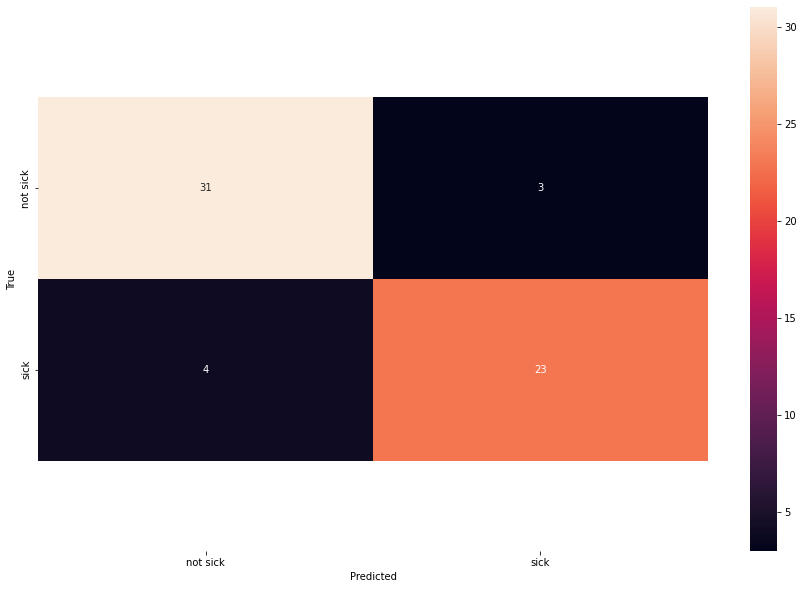

In [160]:
from sklearn.metrics import confusion_matrix

def draw_conf_mat(y_test, y_pred):
    cmat = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (15, 10))
    ax =sns.heatmap(cmat, annot=True)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    ax.set_xticklabels(["not sick", "sick"], ha="center") 
    ax.set_yticklabels(["not sick", "sick"], va="center") 
    # Fix cut off top/bottom cells:
    bot, top = plt.ylim()
    bot += 0.5
    top -= 0.5
    plt.ylim(bot, top)
    plt.show()
    
def report_scores(y_test, y_pred):
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1score = metrics.f1_score(y_test, y_pred)
    print("Accuracy: {}, Precision: {}, Recall: {}, F1 Score: {}"
          .format(accuracy, precision, recall, f1score))
    draw_conf_mat(y_test, y_pred)

y_pred = clf.predict(test_pipe)
report_scores(target_test_pipe, y_pred)

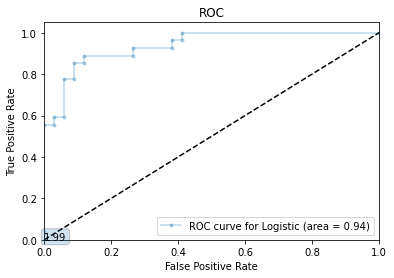

In [168]:
#####
# 3. Make ROC curves to evaluate a model's overall useability.
#####

from sklearn.metrics import roc_curve, auc

# a function to make 'pretty' ROC curves for this model
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax


make_roc("Logistic", clf, target_test_pipe, test_pipe, ax=None, labe=20, proba=True, skip=1);

### Discuss what each measure is reporting, why they are different, and why are each of these measures is significant. Explore why we might choose to evaluate the performance of differing models differently based on these factors. Try to give some specific examples of scenarios in which you might value one of these measures over the others.

Confusion matrix: the number of true positives, true negatives, false positives, false negatives.

Accuracy: % of correct predictions. (True positive + True Negative) / (True Positive + False Positive + True Negative + False Negative). 
Significance: It tells how many data is correctly labeled. 
Scenarios: Good method for balanced data. 

Precision: % of positive predictions that were positive. True Positive / (True Positive + False Positive)
Significance: It tells the ability of our model to label a non-negative dp as positive.
Scenarios: Good method for inbalanced data.

Recall: % of positive cases that were correctly predicted as positive. True Positive / (True Positive + False Negative)
Significance: It tells out models ability to label positive values as positive. 
Scenarios: imbalanced data. 

F1 score: the weighted avg of precision and recall
Significance: The F1 score provides a summary figure to evaluate both precision and recall

One specific scenario: 

In health problems, false negative is the case that a patient gets sick, but diagnosed as healthy. A false positive is the case that a patient is healthy, but is diagnosed as sick. In this case, false positive is better than false negative, and we may weigh false negative more seriously. 

### Describe what an ROC curve is and what the results of this graph seem to be indicating

ROC curve: The probability curce reflects the relationship btwn true positive rate and false positive rate. The area under the curve(area btwn ROC curve and diagonal curve) is probability that a random positive example is classified more positively than a random negative example. Higher AUC indicates a better model at labeling positive as positive and genative as negative. When AUC = 0, the model is all wrong. For AUC = 0.5, the model cannot distinguish the two classes. For AUC = 1, the model label everything right. 

Result of this graph: AUC = 0.94, which is a pretty good classifier. 

### Let's tweak a few settings. First let's set your solver to 'sag', your max_iter= 10, and set penalty = 'none' and rerun your model. Let's see how your results change!

In [162]:
clf_max_iter_10 = LogisticRegression(random_state=0,solver="sag", max_iter=10).fit(train_pipe, target_pipe)

C:\Users\CLICK-USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Accuracy: 0.8852459016393442, Precision: 0.8846153846153846, Recall: 0.8518518518518519, F1 Score: 0.8679245283018868


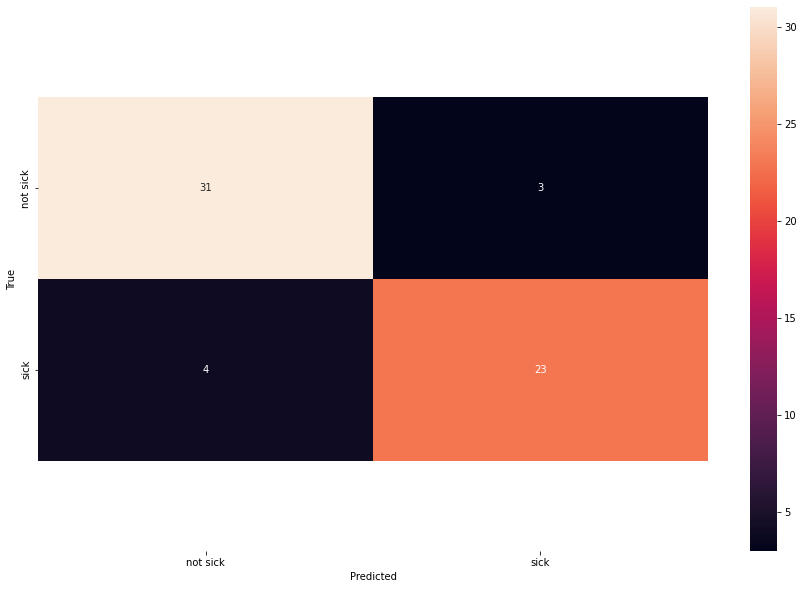

In [163]:
y_pred_10 = clf_max_iter_10.predict(test_pipe)
report_scores(target_test_pipe, y_pred_10)

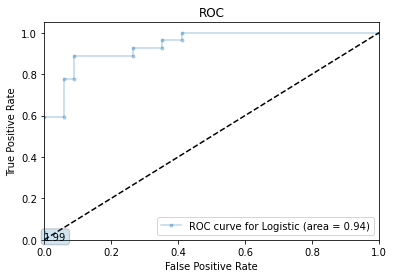

In [169]:
make_roc("Logistic", clf_max_iter_10, target_test_pipe, test_pipe, ax=None, labe=20, proba=True, skip=1);

### Did you notice that when you ran the previous model you got the following warning: "ConvergenceWarning: The max_iter was reached which means the coef_ did not converge". Check the documentation and see if you can implement a fix for this problem, and again report your results.

In [165]:
clf_max_iter_10_change = LogisticRegression(random_state=0,solver="sag", max_iter=3000).fit(train_pipe, target_pipe)

Accuracy: 0.8852459016393442, Precision: 0.8846153846153846, Recall: 0.8518518518518519, F1 Score: 0.8679245283018868


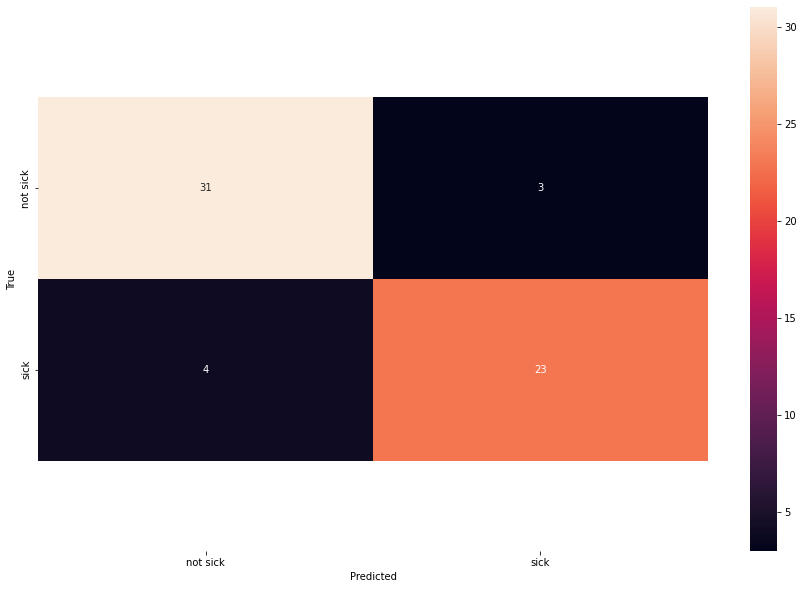

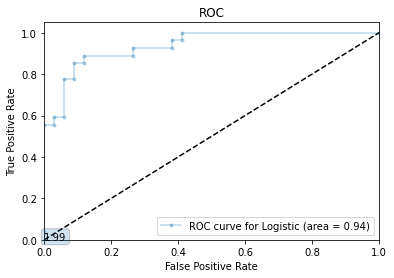

In [170]:
y_pred_10_change = clf_max_iter_10_change.predict(test_pipe)
report_scores(target_test_pipe, y_pred_10_change)
make_roc("Logistic", clf_max_iter_10_change, target_test_pipe, test_pipe, ax=None, labe=20, proba=True, skip=1);

### Explain what you changed, and why do you think, even though you 'fixed' the problem, that you may have harmed the outcome. What other Parameters you set may have impacted this result?

Warning before: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "

I changed max_iter from 10 to 3000 so that coef_ can converge.

The results is the same for me. I think it is because the model already has a good performance before converge.

### Rerun your logistic classifier, but modify the penalty = 'l1', solver='liblinear' and again report the results.

In [171]:
clf_max_iter_11 = LogisticRegression(random_state=0,solver="liblinear",penalty='l1' ).fit(train_pipe, target_pipe)

Accuracy: 0.8852459016393442, Precision: 0.8846153846153846, Recall: 0.8518518518518519, F1 Score: 0.8679245283018868


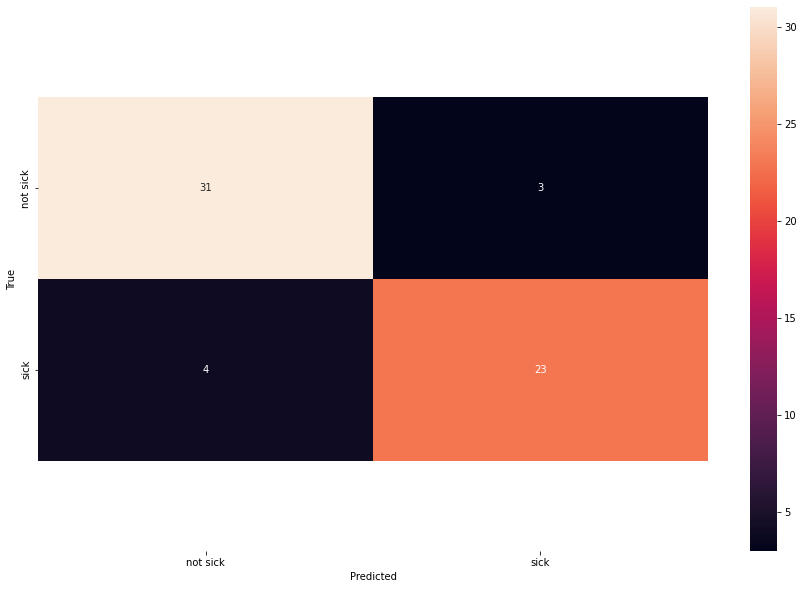

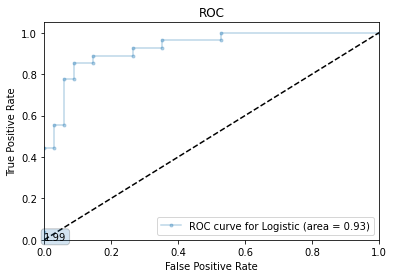

In [172]:
y_pred_11 = clf_max_iter_11.predict(test_pipe)
report_scores(target_test_pipe, y_pred_11)
make_roc("Logistic", clf_max_iter_11, target_test_pipe, test_pipe, ax=None, labe=20, proba=True, skip=1);

### Explain what what the two solver approaches are, and why the liblinear likely produced the optimal outcome. 

liblinear: linear classification that makes a classification decision basd on the value of a lienar combination of the featured values. It is especailly useful for large data sets. 
sag: the stochastic average gradient optimizes the sum of a finite number of smooth convex functions. 

We use L1 for liblinear and l2 for sag, and after adding regulerization, it is more likely to reduce overfitting and make the model more stable. 

### We also played around with different penalty terms (none, L1 etc.) Describe what the purpose of a penalty term is and how an L1 penalty works.

Penalty: Thn the loss function, there is a regularization term. L1 and L2 in panalty represents the level of normalization to improve over-regularizatio. L1 can only choose lib-linear algorithm. For L2, there are newton-cg, lbfgs, liblinear, and sag. I think it is because l1 normalized loss function is not continuous differentiable. 

"Penalized logistic regression imposes a penalty to the logistic model for having too many variables. This results in shrinking the coefficients of the less contributive variables toward zero. This is also known as regularization."

### SVM (Support Vector Machine)

A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In two dimentional space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.

### Implement a Support Vector Machine classifier on your pipelined data. Review the [SVM Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) for how to implement a model. For this implementation you can simply use the default settings, but set probability = True.

In [186]:
svm_clf = SVC(probability=True)
svm_clf.fit(train_pipe, target_pipe)

SVC(probability=True)

### Report the accuracy, precision, recall, F1 Score, and confusion matrix and ROC Curve of the resulting model.

Accuracy: 0.8852459016393442, Precision: 0.8571428571428571, Recall: 0.8888888888888888, F1 Score: 0.8727272727272727


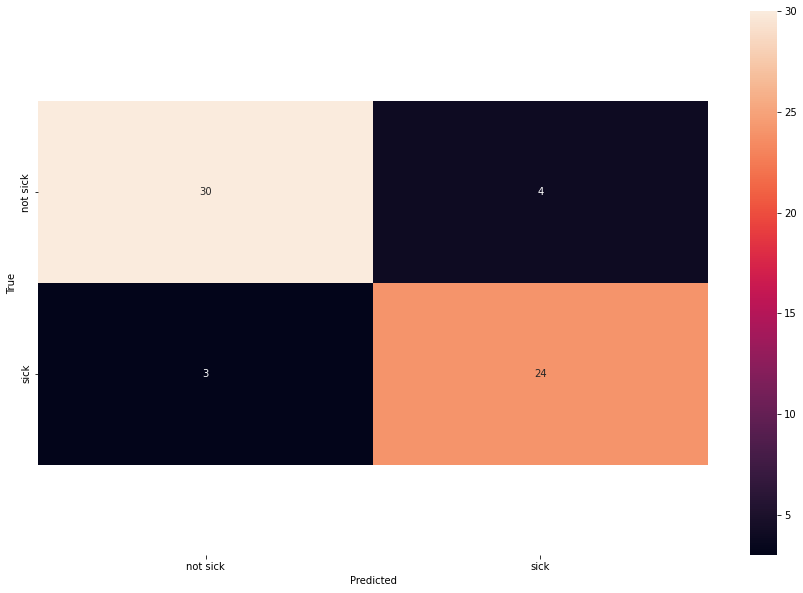

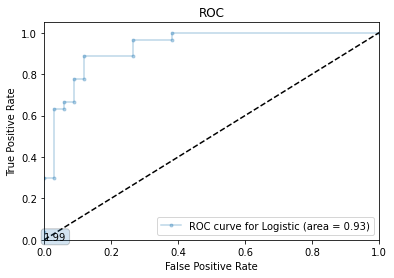

In [187]:
y_pred_svm = svm_clf.predict(test_pipe)
report_scores(target_test_pipe, y_pred_svm)
make_roc("Logistic", svm_clf, target_test_pipe, test_pipe, ax=None, labe=20, proba=True, skip=1);

### Rerun your SVM, but now modify your model parameter kernel to equal 'linear'. Again report your Accuracy, Precision, Recall, F1 scores, and Confusion matrix and plot the new ROC curve.  

In [188]:
svm_clf_lin = SVC(probability=True, kernel = 'linear')
svm_clf_lin.fit(train_pipe, target_pipe)

SVC(kernel='linear', probability=True)

Accuracy: 0.819672131147541, Precision: 0.7666666666666667, Recall: 0.8518518518518519, F1 Score: 0.8070175438596491


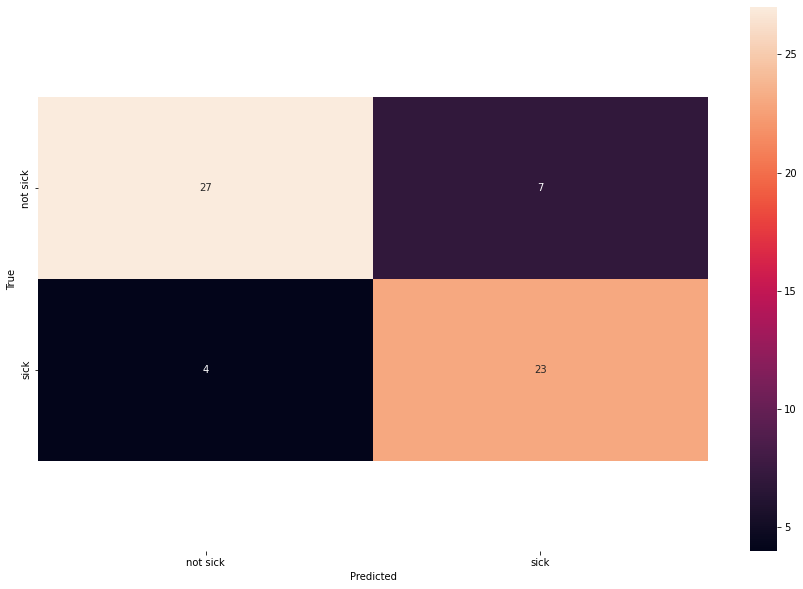

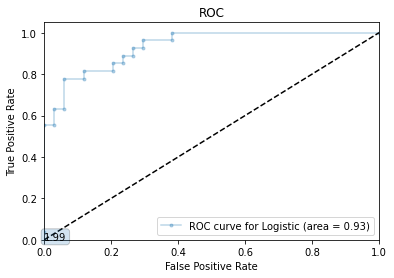

In [189]:
y_pred_svm_lin = svm_clf_lin.predict(test_pipe)
report_scores(target_test_pipe, y_pred_svm_lin)
make_roc("Logistic", svm_clf_lin, target_test_pipe, test_pipe, ax=None, labe=20, proba=True, skip=1);

### Explain the what the new results you've achieved mean. Read the documentation to understand what you've changed about your model and explain why changing that input parameter might impact the results in the manner you've observed.

Result observation: AUC remains the same. Number in matrix slightly decreased.

From the documentation online, the default kernel uses a Radial Basis Function, and the second model we switched to linear kernel. Linear kernels is beeter for classifying linearly separable data, and RBF kernels work on bot linearly and non-linearly separable data. The performance decreased but our data is non-linearly separable. 

### Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary, then what’s the difference between their ways to find this boundary?

Logistic regression: In the sigmoid function between 0 and 1 generated by the data set, we determine a score in btwn, in which the value above and the value below will be classified in two classes. 

Linear SVM: Minimize the sum of square residuals. 

## Baysian (Statistical) Classification

In class we learned about Naive Bayes, and statistical classification.

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. Bayes’ theorem states the following relationship, given class variable Y  and dependent feature vector X1 through Xn. 

### Please implement a Naive Bayes Classifier on the pipelined data. For this model simply use the default parameters. Report out the number of mislabeled points that result, along with the accuracy, precision, recall, F1 Score and Confusion Matrix. Refer to documentation on implementing a NB Classifier [here](https://scikit-learn.org/stable/modules/naive_bayes.html)

In [193]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb_clf = gnb.fit(train_pipe, target_pipe)
y_pred_nb = gnb_clf.predict(test_pipe)

Accuracy: 0.8524590163934426, Precision: 0.8461538461538461, Recall: 0.8148148148148148, F1 Score: 0.830188679245283


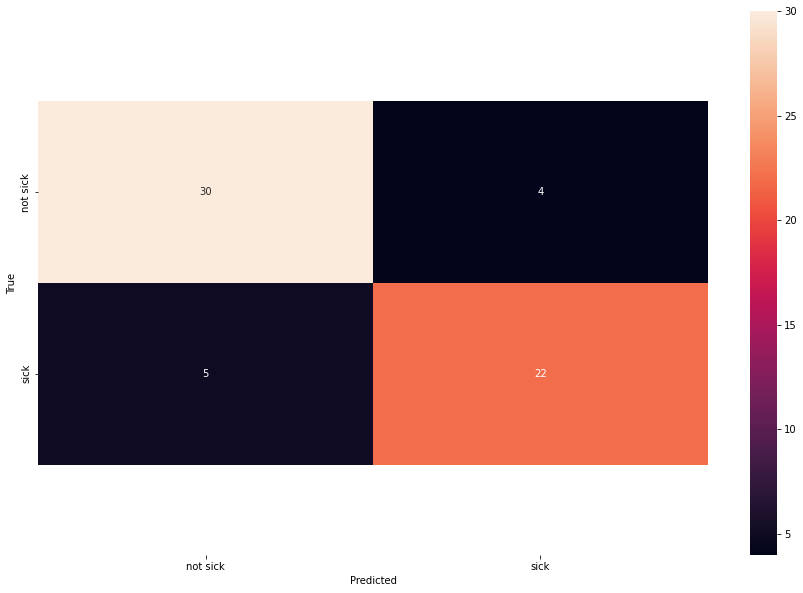

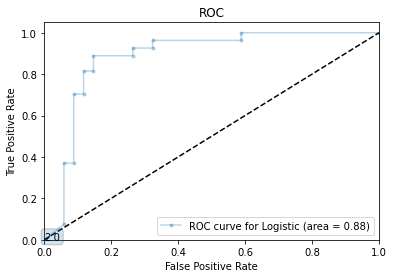

In [194]:
report_scores(target_test_pipe, y_pred_nb)
make_roc("Logistic", gnb_clf, target_test_pipe, test_pipe, ax=None, labe=20, proba=True, skip=1);

### Discuss the observed results. What assumptions about our data are we making here and why might those be inacurate?

Compared to logistic regression and linear svm, the nb classifier result in a lower AUC. 

NB has the assumption of independent predictors, yet many of our predictors are related, this might make our result inaccurate. 

## Cross Validation and Model Selection

You've sampled a number of different classification techniques, leveraging clusters, linear classifiers, and Statistical Classifiers, as well as experimented with tweak different parameters to optimize perfiormance. Based on these experiments you should have settled on a particular model that performs most optimally on the chosen dataset. 

Before our work is done though, we want to ensure that our results are not the result of the random sampling of our data we did with the Train-Test-Split. To ensure otherwise we will conduct a K-Fold Cross-Validation of our top two performing models, assess their cumulative performance across folds, and determine the best model for our particular data. 

## Select your top 2 performing models and run a K-Fold Cross Validation on both (use 10 folds). Report your best performing model.

In [197]:
#model: logistic regression classifier and svm classifier
from sklearn.model_selection import KFold

In [203]:
#logistic regre
cv_r2_scores_rf = cross_val_score(clf, train_pipe, target_pipe, cv=10,scoring='r2')
print(cv_r2_scores_rf)
print("Mean 10-Fold R Squared: {}".format(np.mean(cv_r2_scores_rf)))

[0.02597403 0.03846154 0.4965035  0.32867133 0.66433566 0.16083916
 0.4965035  0.4965035  0.4965035  0.66433566]
Mean 10-Fold R Squared: 0.38686313686313695


In [204]:
#svm
cv_r2_scores_rf = cross_val_score(svm_clf, train_pipe, target_pipe, cv=10,scoring='r2')
print(cv_r2_scores_rf)
print("Mean 10-Fold R Squared: {}".format(np.mean(cv_r2_scores_rf)))

[ 0.02597403 -0.12179487  0.32867133  0.32867133  0.4965035   0.32867133
  0.32867133  0.66433566  0.32867133  0.66433566]
Mean 10-Fold R Squared: 0.3372710622710623


The mean R^2 square score for logistic classifier model > that of svm classifier model. The bst preforming model is logistic classifier model because the corelation coeffient is larger.